In [2]:
import numpy as np
import json
import pandas as pd


from matrix_class import ProteinMatrix
from matrix_class import SubMatrix
from cluster_class import AllClusters
from degreelist_class import DegreeList


from connected_components_utils import *
from analysis_utils import *

from func_e.FUNC_E import FUNC_E # import the class
import func_e.vocabs.all as vocabs

In [3]:
    matrix, clusters, degreelist = initialize_matrix_clusters_degreelist("../data/networks/DREAM_files/dream_3.txt", "../data/results/DREAM-3-cc/d3_5_100.json-cluster.json")
    
    qualifying_clusters, qualifying_proteins = find_clusters_and_proteins_together(matrix, clusters, degreelist, cluster_ratio=pick_ratio(clusters.get_num_clusters()), protein_ratio=.05, protein_constant=2)


    genomic_background_filepath = '../data/testing_data/protein_list.txt'
    termlist = vocabs.getTerms(['GO'])
    term_mapping_filepath = 'term_mapping.txt'
    create_term_mapping_list('../data/go-results/dream_3_go_results.tsv', term_mapping_filepath)



    og_clusters_querylist_path = 'original_querylist.txt'
    clusters.print_querylist_of_clusters_to_file(qualifying_clusters, og_clusters_querylist_path)



    original_fe = FUNC_E()
    original_fe.importFiles({
        'background': genomic_background_filepath, 
        'query': og_clusters_querylist_path, 
        'terms2features': term_mapping_filepath })
    original_fe.setTerms(termlist)
    original_fe.setEnrichmentSettings({'ecut': 0.01})
    original_fe.run(cluster=False)



    update_clusters(clusters, qualifying_proteins)


    updated_clusters_querylist_path = 'new_querylist.txt'
    clusters.print_querylist_of_clusters_to_file(qualifying_clusters, updated_clusters_querylist_path)

    updated_fe = FUNC_E()
    updated_fe.importFiles({
        'background': genomic_background_filepath, 
        'query': updated_clusters_querylist_path, 
        'terms2features': term_mapping_filepath })
    updated_fe.setTerms(termlist)
    updated_fe.setEnrichmentSettings({'ecut': 0.01})
    updated_fe.run(cluster=False)
    
    # print(f"ORIGINAL CLUSTERS TABLE:\n{original_fe.enrichment.sort_values('Fishers_pvalue')}")
    # print(f"UPDATED CLUSTERS TABLE:\n{updated_fe.enrichment.sort_values('Fishers_pvalue')}")




/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modResults = modResults.append({
/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modResults = modResults.append({
/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modResults = modResults.append({
/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

In [23]:
original_df = original_fe.enrichment[['Module', 'Term', 'Fishers_pvalue']].copy()
original_df['Module'] = original_df['Module'] + ' ' + original_df['Term']
original_df.drop('Term', axis=1, inplace=True)


In [24]:

updated_df = updated_fe.enrichment[['Module', 'Term', 'Fishers_pvalue']].copy()

updated_df['Module'] = updated_df['Module'] + ' ' + updated_df['Term']
updated_df.drop('Term', axis=1, inplace=True)
updated_df.rename(columns = {'Fishers_pvalue':'Updated_Fishers_pvalue'}, inplace = True)



In [26]:
print(f"ORIGINAL CLUSTERS TABLE:\n{original_df}")
print(f"UPDATED CLUSTERS TABLE:\n{updated_df}")

ORIGINAL CLUSTERS TABLE:
                    Module Fishers_pvalue
0   cluster_161 GO:0030175       0.002023
1   cluster_161 GO:0032465       0.007341
2   cluster_164 GO:0005741       0.007455
3   cluster_164 GO:0043276       0.008671
4   cluster_164 GO:0045453       0.000438
5   cluster_164 GO:0060444       0.008671
6   cluster_174 GO:0050679       0.005841
7   cluster_185 GO:0016241       0.007339
8   cluster_185 GO:0016485       0.005832
9   cluster_185 GO:0030216       0.004486
10  cluster_185 GO:0055038       0.007339
11  cluster_185 GO:0070507       0.002297
12  cluster_185 GO:0072659       0.001876
13   cluster_25 GO:0007346       0.007487
14   cluster_25 GO:0032728       0.005714
15   cluster_25 GO:0035666       0.007487
16   cluster_29 GO:0001656       0.002948
17   cluster_29 GO:0008630       0.003013
18   cluster_29 GO:0048536        0.00033
19   cluster_29 GO:0071897       0.002948
20   cluster_30 GO:0007223       0.004462
21   cluster_30 GO:0030136       0.003596
22   clus

In [32]:
results_df = pd.merge(original_df, updated_df, on=['Module'], how='outer')

In [33]:
print(results_df)

                    Module Fishers_pvalue Updated_Fishers_pvalue
0   cluster_161 GO:0030175       0.002023               0.002202
1   cluster_161 GO:0032465       0.007341               0.007827
2   cluster_164 GO:0005741       0.007455               0.003026
3   cluster_164 GO:0043276       0.008671                    NaN
4   cluster_164 GO:0045453       0.000438               0.000849
..                     ...            ...                    ...
60   cluster_49 GO:0038128            NaN               0.006028
61   cluster_49 GO:0043406            NaN               0.005061
62   cluster_73 GO:0007268            NaN               0.009189
63   cluster_73 GO:0018105            NaN                0.00569
64   cluster_73 GO:0046827            NaN                0.00736

[65 rows x 3 columns]


In [35]:
results_df.to_csv("results.txt", sep='\t')


In [38]:
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='Module'>

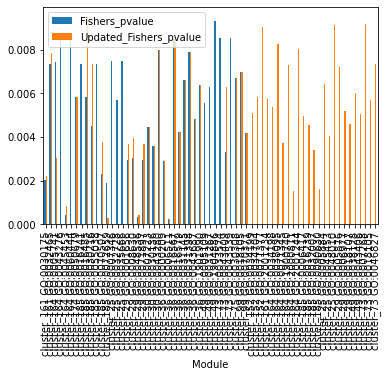

In [39]:
results_df.plot(x="Module", y=["Fishers_pvalue", "Updated_Fishers_pvalue"], kind="bar")

In [40]:
changes_df = (results_df.copy()).dropna(axis=0)

<AxesSubplot:xlabel='Module'>

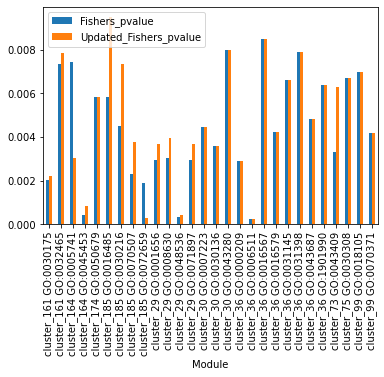

In [41]:
changes_df.plot(x="Module", y=["Fishers_pvalue", "Updated_Fishers_pvalue"], kind="bar")

this graph ^ is interesting bc it shows that p-values increase (less significant). this shows that maybe we are adding proteins to the wrong clusters. it will be interesting to go back and tweak the functions and see how adding different things affects everything